In [1]:
%%capture --no-stderr
#%pip install --quiet -U langgraph langchain_anthropic

In [2]:
from dotenv import load_dotenv
load_dotenv('../envls')

import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        on.environ[var] = getpass.getpass(f"{var}:")

_set_env("ANTHROPIC_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
_set_env("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

In [3]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

# Add messages essentially does this with more
# robust handling
# def add_messages(left: list, right: list):
#     return left + right


class State(TypedDict):
    messages: Annotated[list, add_messages]

### 툴 사용방법 

https://python.langchain.com/v0.2/docs/how_to/custom_tools/

In [4]:
# tool setup
# 툴 생성
from langchain_core.tools import tool

@tool
def search(query: str):
    """ Call to surf the web. """
    return ["The answer to your question lies within."]

tools = [search]


In [5]:
from langgraph.prebuilt import ToolNode

# 툴 노드 생성
tool_node = ToolNode(tools)

In [6]:
from langchain_openai import ChatOpenAI

# We will set streaming=True so that we can stream tokens
# See the streaming section for more information on this.
model = ChatOpenAI(temperature=0, streaming=True)

In [7]:
# 모델과 도구 바인딩
bound_model = model.bind_tools(tools)


In [8]:
# 그래프 정의
"""
    노드는 함수나 runnable 클래스가 될 수 있다.
    1. Agent: 무엇을 실행할지 결정해야 한다.
    2. 툴을 실행하는 함수: 실제로 동작해서 주어진 것을 실행한다.

    엣지 정의
    단순한 연결일 수도 있고, 조건부 연결이 될 수 있다.
    노드의 결과에 따라 이후 연결할 노드가 결정될 수 있다. 툴과 바인딩된 LLM에 따라 툴이 결정되기 전까지 아무도 모른다)

    1. 조건부 엣지: Agent가 툴을 호출하여 실행할 수도 있고, 종료할 수도 있다.
    2. 일반 엣지: 툴이 실행된 이후 Agent에게 다시 돌아갑니다.
"""

'\n    노드는 함수나 runnable 클래스가 될 수 있다.\n    1. Agent: 무엇을 실행할지 결정해야 한다.\n    2. 툴을 실행하는 함수: 실제로 동작해서 주어진 것을 실행한다.\n\n    엣지 정의\n    단순한 연결일 수도 있고, 조건부 연결이 될 수 있다.\n    노드의 결과에 따라 이후 연결할 노드가 결정될 수 있다. 툴과 바인딩된 LLM에 따라 툴이 결정되기 전까지 아무도 모른다)\n\n    1. 조건부 엣지: Agent가 툴을 호출하여 실행할 수도 있고, 종료할 수도 있다.\n    2. 일반 엣지: 툴이 실행된 이후 Agent에게 다시 돌아갑니다.\n'

In [9]:
from typing import Literal

def should_continue(state: State) -> Literal["action", "__end__"]:
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # If there is no function call, then we finish
    # Agent가 툴을 호출하면 tool_calls가 존재한다.
    if not last_message.tool_calls:
        return "__end__"
    return "action"

def call_model(state: State):
    response = model.invoke(state["messages"])
    return {"messages": response}

In [10]:
# 그래프 생성
from langgraph.graph import StateGraph, START

# 그래프 빌더 생성
workflow = StateGraph(State)

# 노드 생성
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# 그래프 시작 지점 정의
workflow.add_edge(START, "agent")

workflow.add_conditional_edges(
    # 시작 노드 설정
    "agent",
    # 어떤 노드를 선택할 것인지 결정
    should_continue
)

# 툴에서 agent로 연결
workflow.add_edge("action", "agent")

In [11]:
# 지속성을 추가하기 위해 그래프를 컴파일할 때 checkpoint를 추가
# postgresql을 사용할 수 있음
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [12]:
# 컴파일된 결과는 Runnable 클래스와 함께 사용할 수 있다.
app = workflow.compile(checkpointer=memory)

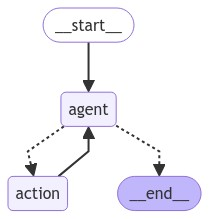

In [13]:
# 랭그래프 클라우드를 사용하면 자동으로 checkpointer가 적용됨
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [15]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "2"}}
input_message = HumanMessage(content="hi! I'm bob")


for event in app.stream({"messages": [input_message]}, config, stream_mode="values", debug=True):
    event["messages"][-1].pretty_print()

[2:checkpoint] State at the end of step 2:
{'messages': [HumanMessage(content="hi! I'm bob", id='7d3fa6bd-e1bf-4720-a044-93710a777dc2'),
              AIMessage(content='Hello Bob! How can I assist you today?', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-eadda51d-6226-4763-a267-2f242e32312e-0')]}
[3:tasks] Starting step 3 with 1 task:
- __start__ -> {'messages': [HumanMessage(content="hi! I'm bob")]}
[3:writes] Finished step 3 with writes to 1 channel:
- messages -> [HumanMessage(content="hi! I'm bob")]
================================ Human Message =================================

hi! I'm bob
[3:checkpoint] State at the end of step 3:
{'messages': [HumanMessage(content="hi! I'm bob", id='7d3fa6bd-e1bf-4720-a044-93710a777dc2'),
              AIMessage(content='Hello Bob! How can I assist you today?', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-eadda51d-6226-4763-a267-2f242e32312e-0'),
          

In [17]:
input_message = HumanMessage(content="what is my name?")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values", debug=True):
    event["messages"][-1].pretty_print()

[5:checkpoint] State at the end of step 5:
{'messages': [HumanMessage(content="hi! I'm bob", id='7d3fa6bd-e1bf-4720-a044-93710a777dc2'),
              AIMessage(content='Hello Bob! How can I assist you today?', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-eadda51d-6226-4763-a267-2f242e32312e-0'),
              HumanMessage(content="hi! I'm bob", id='9fd1bb45-41e9-4f3e-a8c8-1a2b627fbf81'),
              AIMessage(content="Hello Bob! It seems like you've introduced yourself twice. How can I assist you today?", response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-ac67ddcd-f4ef-4295-99b1-f37058ce436c-0')]}
[6:tasks] Starting step 6 with 1 task:
- __start__ -> {'messages': [HumanMessage(content='what is my name?')]}
[6:writes] Finished step 6 with writes to 1 channel:
- messages -> [HumanMessage(content='what is my name?')]
================================ Human Message =================================

what is

In [18]:
# thread_id를 변경하면 기억이 사라짐
input_message = HumanMessage(content="what is my name?")
for event in app.stream(
    {"messages": [input_message]},
    {"configurable": {"thread_id": "3"}, "recursion_limit": 10},
    stream_mode="values",
    debug=True
):
    event["messages"][-1].pretty_print()

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting step 0 with 1 task:
- __start__ -> {'messages': [HumanMessage(content='what is my name?')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [HumanMessage(content='what is my name?')]
================================ Human Message =================================

what is my name?
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='what is my name?', id='429c6b3d-ad25-4cf8-9ed6-68b59a35f4b1')]}
[1:tasks] Starting step 1 with 1 task:
- agent -> {'messages': [HumanMessage(content='what is my name?', id='429c6b3d-ad25-4cf8-9ed6-68b59a35f4b1')]}
[1:writes] Finished step 1 with writes to 1 channel:
- messages -> AIMessage(content="I'm sorry, I do not know your name as I am an AI assistant and do not have access to personal information.", response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-a3b59bb1-215d-4bb0-828e-92248195eac0-0')


In [19]:
# 없어진 것은 아니기 때문에 계속 사용할 수 있음
input_message = HumanMessage(content="You forgot??")
for event in app.stream(
    {"messages": [input_message]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

You forgot??
================================== Ai Message ==================================

My apologies, Bob! I did not forget your name. I was just confirming it with you. How can I assist you today?
